In [10]:

import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from sklearn.cluster import DBSCAN
from sklearn.preprocessing import StandardScaler
from sklearn.neighbors import NearestNeighbors
from sklearn.metrics import silhouette_score
# دیکشنری شیت‌های هزینه
p3_sheets = {
    'Food': 'Food',
    'Tobacco': 'Tobacco',
    'Clothing': 'Clothing',
    'Housing': 'Housing',
    'Furniture': 'Furniture',
    'Health': 'Health',
    'Transport': 'Transport',
    'Communication': 'Communication',
    'Recreation': 'Recreation',
    'Education': 'Education',
    'Hotel': 'Hotel',
    'Miscellaneous': 'Miscellaneous',
    'Investment': 'Investment'
}

## Feature Extraction

In [2]:
def read_expenditure_data(file_prefix, year):
    file_name = f'{file_prefix}{year}_cleaned.xlsx'
    expenditure_data_list = []

    # استفاده از نام شیت‌های واقعی در فایل اکسل
    for sheet_name in p3_sheets.keys():
        try:
            df = pd.read_excel(file_name, sheet_name=sheet_name)
            if 'Address' in df.columns and ('value' in df.columns or 'Value' in df.columns):
                value_column = 'value' if 'value' in df.columns else 'Value'
                df[value_column] = pd.to_numeric(df[value_column], errors='coerce').fillna(0)
                if sheet_name == 'Housing' and 'mortgage' in df.columns:
                    df['mortgage'] = pd.to_numeric(df['mortgage'], errors='coerce').fillna(0)
                    df['total_value'] = df[value_column] + df['mortgage']
                else:
                    df['total_value'] = df[value_column]
                df_grouped = df.groupby('Address')['total_value'].sum().reset_index()
                df_grouped.rename(columns={'total_value': f'Expenditure_{sheet_name}'}, inplace=True)
                expenditure_data_list.append(df_grouped)
            else:
                print(f'ستون‌های مورد نیاز در شیت {sheet_name} یافت نشدند.')
                continue
        except Exception as e:
            print(f'خطا در خواندن شیت {sheet_name}: {e}')
            continue

    # ادغام تمامی داده‌های هزینه‌ای
    if expenditure_data_list:
        expenditure_data = pd.concat(expenditure_data_list, axis=0, ignore_index=True)
        # جمع کردن هزینه‌ها برای هر Address
        expenditure_data = expenditure_data.groupby('Address').sum().reset_index()
        # محاسبه کل هزینه‌ها
        expenditure_columns = [col for col in expenditure_data.columns if col.startswith('Expenditure_')]
        expenditure_data['Expenditure'] = expenditure_data[expenditure_columns].sum(axis=1)
        return expenditure_data
    else:
        raise ValueError("No valid data to concatenate in expenditure sheets.")



In [3]:
def read_income_data(file_prefix, year):
    file_name = f'{file_prefix}{year}_cleaned.xlsx'
    income_sheets = [f'{file_prefix}{year}P4S01', f'{file_prefix}{year}P4S02', f'{file_prefix}{year}P4S03', f'{file_prefix}{year}P4S04']
    income_data_list = []
    for sheet_name in income_sheets:
        try:
            df = pd.read_excel(file_name, sheet_name=sheet_name)
            if 'Address' in df.columns:
                income_columns = []
                if sheet_name.endswith('P4S01'):
                    income_columns = ['income_w_y', 'wage_w_y', 'perk_w_y', 'netincome_w_y']
                elif sheet_name.endswith('P4S02'):
                    income_columns = ['income_s_y', 'sale']
                elif sheet_name.endswith('P4S03'):
                    income_columns = ['income_pension', 'income_rent', 'income_interest', 'income_aid', 'income_resale', 'income_transfer']
                elif sheet_name.endswith('P4S04'):
                    income_columns = ['subsidy']
                income_columns = [col for col in income_columns if col in df.columns]
                for col in income_columns:
                    df[col] = pd.to_numeric(df[col], errors='coerce').fillna(0)
                df['Total_Income'] = df[income_columns].sum(axis=1)
                df_grouped = df.groupby('Address')['Total_Income'].sum().reset_index()
                income_data_list.append(df_grouped)
            else:
                print(f'ستون "Address" در شیت {sheet_name} یافت نشد.')
                continue
        except Exception as e:
            print(f'خطا در خواندن شیت {sheet_name}: {e}')
            continue
    if income_data_list:
        income_data = pd.concat(income_data_list, axis=0, ignore_index=True)
        income_data = income_data.groupby('Address').sum().reset_index()
        income_data.rename(columns={'Total_Income': 'Income'}, inplace=True)
        return income_data
    else:
        raise ValueError("No valid data to concatenate in income sheets.")

In [4]:
# لیست سال‌ها
years = [98, 99, 1400, 1401]

# لیست پیشوندهای فایل برای داده‌های شهری و روستایی
file_prefixes = ['U', 'R']

expenditure_data_list = []
income_data_list = []
household_data_list = []

for file_prefix in file_prefixes:
    for year in years:
        try:
            expenditure_data = read_expenditure_data(file_prefix, year)
            income_data = read_income_data(file_prefix, year)
            household_data = pd.read_excel(f'{file_prefix}{year}_cleaned.xlsx', sheet_name=f'{file_prefix}{year}Data')

            # اضافه کردن سال و نوع سکونت به داده‌ها
            expenditure_data['Year'] = 1300 + year
            income_data['Year'] = 1300 + year
            household_data['Year'] = 1300 + year
            household_data['Type'] = file_prefix  # U برای شهری و R برای روستایی

            expenditure_data_list.append(expenditure_data)
            income_data_list.append(income_data)
            household_data_list.append(household_data)
        except Exception as e:
            print(f'خطا در پردازش فایل {file_prefix}{year}_cleaned.xlsx: {e}')
            continue

In [6]:
# ترکیب داده‌ها
all_expenditure_data = pd.concat(expenditure_data_list, ignore_index=True)
all_income_data = pd.concat(income_data_list, ignore_index=True)
all_household_data = pd.concat(household_data_list, ignore_index=True)

In [7]:
# ادغام داده‌ها
data = all_household_data.merge(all_income_data, on=['Address', 'Year'], how='left')
data = data.merge(all_expenditure_data, on=['Address', 'Year'], how='left')

# جایگزینی مقادیر NaN با صفر در درآمد و هزینه
data['Income'] = data['Income'].fillna(0)
data['Expenditure'] = data['Expenditure'].fillna(0)

# حذف خانوارهایی که درآمد و هزینه آنها صفر است
data = data[(data['Income'] > 0) | (data['Expenditure'] > 0)]

In [8]:
# محاسبه لگاریتم درآمد و هزینه
data['Log_Income'] = np.log1p(data['Income'])
data['Log_Expenditure'] = np.log1p(data['Expenditure'])

c:\Users\Admin\AppData\Local\Programs\Python\Python312\Lib\site-packages\pandas\core\arraylike.py:399: RuntimeWarning: invalid value encountered in log1p
  result = getattr(ufunc, method)(*inputs, **kwargs)


In [11]:
# آماده‌سازی داده‌ها برای خوشه‌بندی
X = data[['Log_Income', 'Log_Expenditure']].values

# مقیاس‌دهی داده‌ها
scaler = StandardScaler()
X_scaled = scaler.fit_transform(X)

In [12]:
# حذف ردیف‌هایی که Income یا Expenditure کمتر یا مساوی صفر دارند
data = data[(data['Income'] > 0) & (data['Expenditure'] > 0)]

In [13]:
# محاسبه لگاریتم درآمد و هزینه
data['Log_Income'] = np.log(data['Income'])
data['Log_Expenditure'] = np.log(data['Expenditure'])

In [14]:
# بررسی وجود مقادیر NaN یا inf در داده‌ها
print("تعداد مقادیر NaN در Log_Income:", data['Log_Income'].isna().sum())
print("تعداد مقادیر NaN در Log_Expenditure:", data['Log_Expenditure'].isna().sum())

print("تعداد مقادیر inf در Log_Income:", np.isinf(data['Log_Income']).sum())
print("تعداد مقادیر inf در Log_Expenditure:", np.isinf(data['Log_Expenditure']).sum())


تعداد مقادیر NaN در Log_Income: 0
تعداد مقادیر NaN در Log_Expenditure: 0
تعداد مقادیر inf در Log_Income: 0
تعداد مقادیر inf در Log_Expenditure: 0


In [15]:
# حذف ردیف‌های حاوی NaN یا inf
data = data.replace([np.inf, -np.inf], np.nan)
data = data.dropna(subset=['Log_Income', 'Log_Expenditure'])


In [16]:
# آماده‌سازی داده‌ها برای خوشه‌بندی
X = data[['Log_Income', 'Log_Expenditure']].values

# مقیاس‌دهی داده‌ها
scaler = StandardScaler()
X_scaled = scaler.fit_transform(X)

# اجرای الگوریتم K-Means
kmeans = KMeans(n_clusters=10, random_state=42)
kmeans.fit(X_scaled)
data['Cluster'] = kmeans.labels_


In [17]:
# استخراج مراکز خوشه‌ها
cluster_centers = scaler.inverse_transform(kmeans.cluster_centers_)


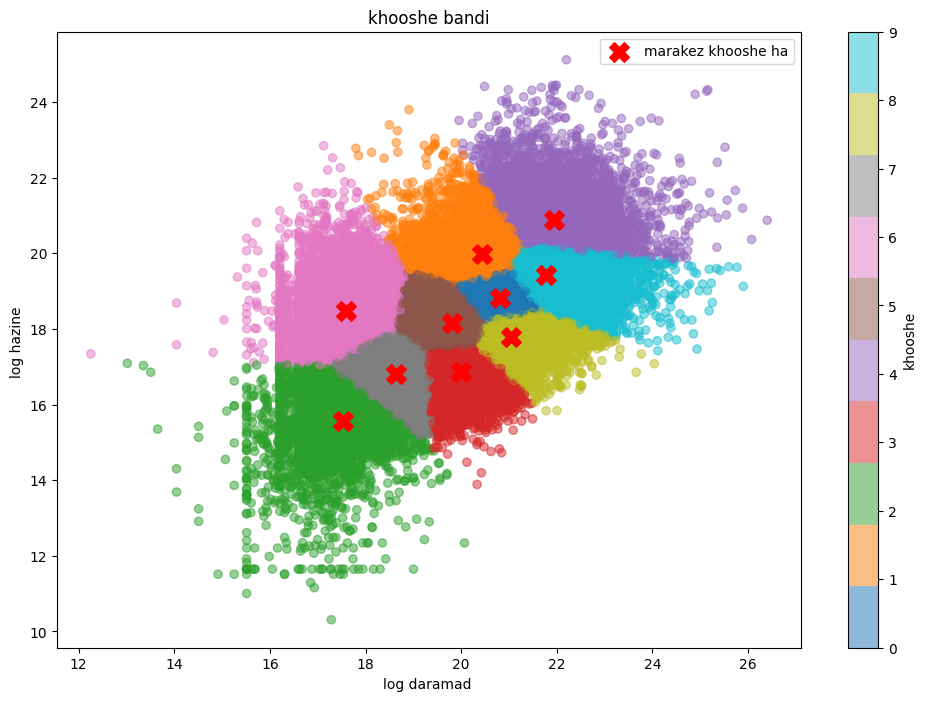

In [18]:
# بصری‌سازی نتایج
plt.figure(figsize=(12,8))
scatter = plt.scatter(data['Log_Income'], data['Log_Expenditure'], c=data['Cluster'], cmap='tab10', alpha=0.5)
plt.scatter(cluster_centers[:,0], cluster_centers[:,1], c='red', marker='X', s=200, label='marakez khooshe ha')
plt.xlabel('log daramad ')
plt.ylabel('log hazine ')
plt.title('khooshe bandi')
plt.legend()
plt.colorbar(scatter, ticks=range(10), label='khooshe')
plt.show()

## Section 2 (KMean Best Hyper Parameter)

مقدار بهینه k بر اساس Elbow: 2


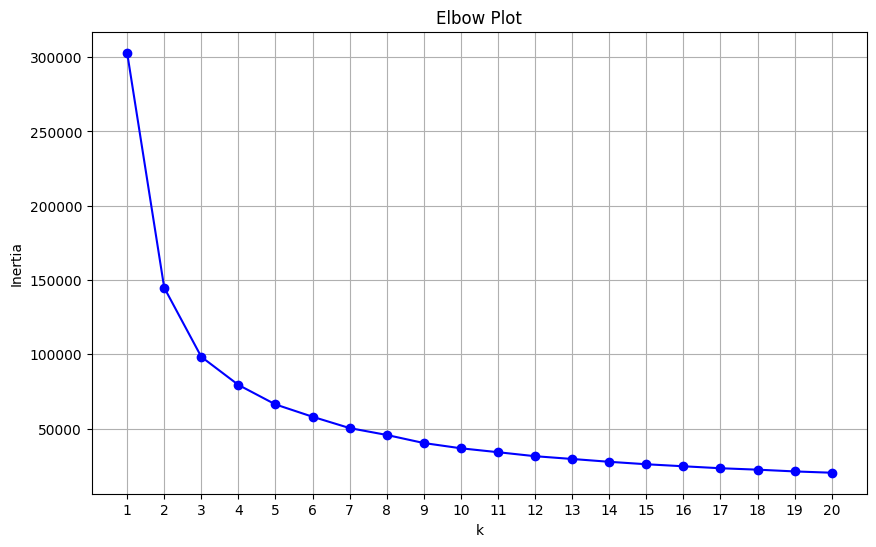

In [22]:
import numpy as np
from sklearn.cluster import KMeans
from sklearn.preprocessing import StandardScaler
import matplotlib.pyplot as plt

# استانداردسازی داده‌ها
scaler = StandardScaler()
X_scaled = scaler.fit_transform(X)

# اجرای KMeans برای kهای مختلف
inertias = []
K = range(1, 21)
for k in K:
    model = KMeans(n_clusters=k, random_state=42)
    model.fit(X_scaled)
    inertias.append(model.inertia_)

# محاسبه اختلاف بین Inertia‌ها برای پیدا کردن نقطه Elbow
diff_inertia = np.diff(inertias)
second_diff_inertia = np.diff(diff_inertia)

# پیدا کردن نقطه‌ای که بیشترین کاهش دارد
optimal_k_elbow = np.argmax(second_diff_inertia) + 2  # +2 چون diff دو بار محاسبه شده

print(f"مقدار بهینه k بر اساس Elbow: {optimal_k_elbow}")

# رسم Elbow plot
plt.figure(figsize=(10, 6))
plt.plot(K, inertias, 'bo-')
plt.title('Elbow Plot')
plt.xlabel('k')
plt.ylabel('Inertia')
plt.xticks(K)
plt.grid(True)
plt.show()
